# Soft Margin Classifier Scratch

✅간략한 설명
* 실제 데이터는 noise가 존재하기 때문에, hard margin svm으로 클래스가 명확하게 구분되기는 어려움 
* soft margin svm은 마진 평면을 넘어가는 인스턴스를 허용하는 SVM임 
* 마진 평면을 넘어가는 인스턴스에 대해서 떨어진 거리에 비례하여 패널티 부여 
<br/>

✅한계점
* 데이터가 선형으로 분리되지 않는 경우에는 오차를 얼마나 허용해주는지가 다 의미 없음 
<br/>

**자세한 설명은 [README](https://github.com/Moonmoonji/Business_Analytics-2022-/blob/main/Kernel-based%20Learning/README.md)에 나와있습니다** 👌

### 라이브러리 import 및 plotting 모듈 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [3]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

## 데이터 생성 

🧾Hard margin에서와 마찬가지로 두 가우시안으로 만들어진 데이터를 재사용하되, 분산을 더 크게 만들어서 데이터를 생성함

In [4]:
colors = ['red','green']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N= 100 

In [5]:
def generateBatchBipolar(n, mu=0.5, sigma=0.2):
    """ Two gaussian clouds on each side of the origin """
    X = np.random.normal(mu, sigma, (n, 2))
    yB = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y = 2. * yB - 1
    X *= y[:, np.newaxis]
    X -= X.mean(axis=0)
    return X, y

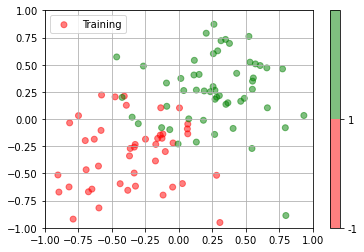

In [6]:
xTrain1, yTrain1 = generateBatchBipolar(N, mu=0.3, sigma=0.3)
plotSvm(xTrain1, yTrain1, label='Training')

## Soft Margin SVM 수식 기반 구현 

Equivalently :
$$ \min_{w, b} \frac 12 \Vert w \Vert^2 + C \sum_{i=1}^n \xi_i$$
__Subject to $\forall i = 1..n$:__
- $\xi_i \ge 0$
- $y_i(x_i^T w + b) \ge 1 - \xi_i$

목적식과 제약식이 라그랑지안 문제로 변환:
$$\mathcal{L}_p(w, b, \alpha, \mu) = \frac 12 \Vert w \Vert^2 - \sum_{i=0}^n \alpha_i (y_i(x_i^T w + b) - (1 - \xi_i) - \sum_{i=0}^n \mu_i \xi_i  $$

__Subject to $\forall i\in 1..n$:__
- $\alpha_i \ge 0$
- $\mu_i \ge 0$
- $\xi_i \ge 0$

KKT 조건에 의해 , 다음과 같은 등식 성립 : 
$$\begin{align}
\sum_{i=0}^n \alpha_i y_i x_i &= w \\
\sum_{i=0}^n \alpha_i y_i &= 0 \\
\alpha_i &= C - \mu_i
\end{align}$$

라그랑지안 문제가 Dual 문제로 변환 : 
$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k x_i^T x_k \\
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \langle \alpha_i y_i x_i, \alpha_k y_k  x_k \rangle \\
\end{align}$$

__Subject to $\forall i\in 1..n$:__
- $0 \le \alpha_i \le C$
- $\sum_{i=0}^n \alpha_i y_i = 0$

In [7]:
class LinearSvmClassifier:
    
    def __init__(self, C):
        self.C = C                                 # <---
        self.alpha = None
        self.w = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # Gram matrix of (X.y)
        Xy = X * y[:, np.newaxis]
        GramXy = np.matmul(Xy, Xy.T)

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        self.w = np.sum((self.alpha[:, np.newaxis] * Xy), axis=0)  
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        # Support vectors is at a distance <= 1 to the separation plan
        # => use min support vector to compute the intercept, assume label is in {-1, 1}
        signedDist = np.matmul(self.supportVectors, self.w)
        minDistArg = np.argmin(signedDist)
        supportLabels = y[self.alpha > epsilon]
        self.intercept = supportLabels[minDistArg] - signedDist[minDistArg]
    
    def predict(self, X):
        """ Predict y value in {-1, 1} """
        assert(self.w is not None)
        assert(self.w.shape[0] == X.shape[1])
        return 2 * (np.matmul(X, self.w) > 0) - 1

In [8]:
model10 = LinearSvmClassifier(C=1)
model10.fit(xTrain1, yTrain1)
model10.w, model10.intercept

(array([2.58062207, 2.01617037]), 0.12747384674610207)

Number of support vectors = 39


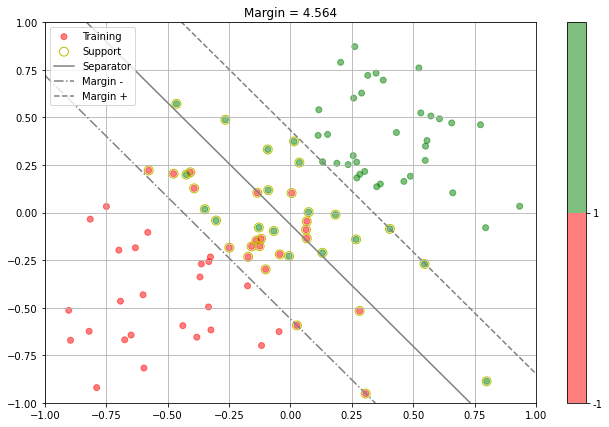

In [9]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, model10.supportVectors, model10.w, model10.intercept, label='Training', ax=ax)

## Scikit Learn 사용해서 Soft Margin SVM 구현

In [10]:
model11 = svm.SVC(kernel='linear', gamma='auto', C = 1)
model11.fit(xTrain1, yTrain1)
model11.coef_[0], model11.intercept_[0]

(array([2.58037163, 2.01759354]), 0.12847619804885338)

Number of support vectors = 39


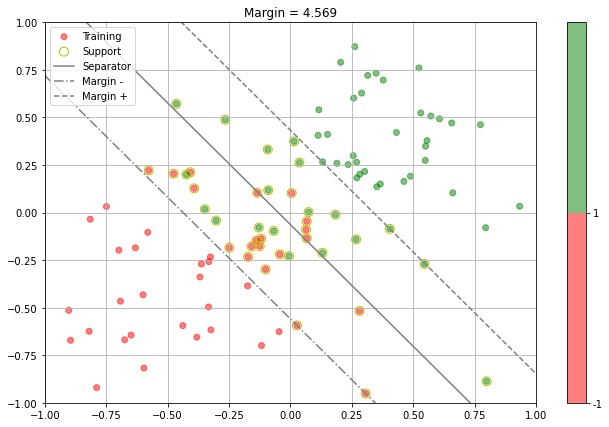

In [11]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, model11.support_vectors_, model11.coef_[0], model11.intercept_[0], 
        label='Training', ax=ax)

## Logistic Regression과 LDA와의 비교 

In [12]:
model12 = linear_model.LogisticRegression(solver='lbfgs')
model12.fit(xTrain1, yTrain1)
model12.coef_[0], model12.intercept_[0]

(array([2.81519297, 2.67392524]), 0.3271442050565857)

In [13]:
model13 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model13.fit(xTrain1, yTrain1)
model13.coef_[0], model13.intercept_[0]

(array([5.70730538, 5.60770452]), 0.5430737856235008)

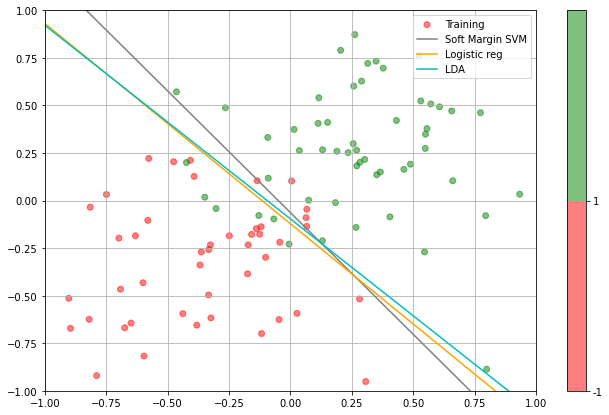

In [14]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain1, yTrain1, w=model11.coef_[0], intercept=model11.intercept_[0], label='Training',
        separatorLabel='Soft Margin SVM', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model12.coef_[0], x0=model12.intercept_[0], label='Logistic reg', color='orange')
plotLine(ax, xx, w=model13.coef_[0], x0=model13.intercept_[0], label='LDA', color='c')
ax.legend();

🔎 결과 해석 :
<br/>
시각화 한 것만으로 비교해보면 Soft Margin SVM이 Logistic regression, LDA 대비 분류기의 성능이 우수한 것처럼 보인다. 

## Validation

In [15]:
xTest1, yTest1 = generateBatchBipolar(2*N, mu=0.3, sigma=0.3)

In [18]:
# Heatmap, Confusion Matrix 구하는 코드 
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', ylabel='True values');

### Confusion Matrix

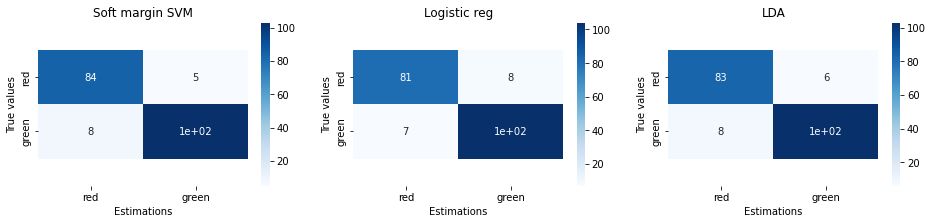

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3))
for model, ax, title in zip([model10, model12, model13], axes, ['Soft margin SVM', 'Logistic reg', 'LDA']):
    yEst = model.predict(xTest1)
    plotConfusionMatrix(yTest1, yEst, colors, title, ax=ax)

🔎 결과 해석 :
<br/>
confusion matrix를 도출해서 비교한 결과, 어떤 것이 더 좋다고 말하기 애매하지만 Soft margin SVM이 red에 해당하는 데이터를 다른 보델 대비 더 정확하게 분류한 것을 알 수 있다.  

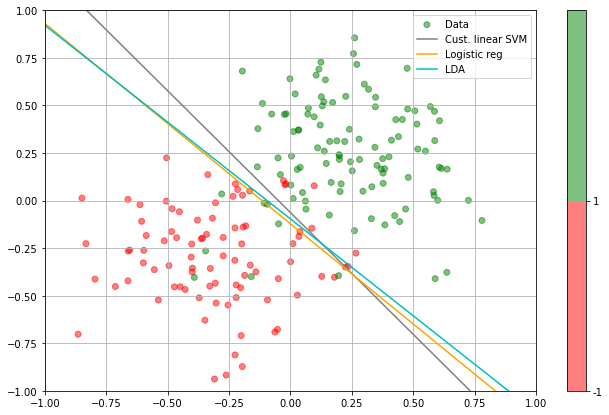

In [21]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTest1, yTest1, w=model10.w, intercept=model10.intercept, separatorLabel='Cust. linear SVM', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model12.coef_[0], x0=model12.intercept_[0], label='Logistic reg', color='orange')
plotLine(ax, xx, w=model13.coef_[0], x0=model13.intercept_[0], label='LDA', color='c')
ax.legend();